## Read data

In [280]:
import pandas as pd
import numpy as np

df = pd.read_csv('spotify-songs-preprocessed.csv')
df_backup = df.__deepcopy__()

df.head()

,artist_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,duration_ms,album_songs,popular,genre_pop,genre_rap,genre_dance pop,genre_hip hop,genre_pop rap,genre_rock,genre_r&b
0,71,0.853,0.606,0.0,66.0,1.0,0.0713,0.0561,0.000000,0.313,...,227600.0,2,True,1,1,0,0,1,0,0
1,69,0.514,0.911,1.0,30.0,0.0,0.4100,0.0559,0.000000,0.775,...,254027.0,3,False,1,0,1,0,0,0,1
2,88,0.780,0.768,6.0,63.0,0.0,0.2380,0.0371,0.000002,0.518,...,404107.0,1,True,0,1,0,1,0,0,0
3,71,0.766,0.563,9.0,87.0,0.0,0.0339,0.0263,0.683000,0.115,...,230640.0,2,True,1,0,1,0,0,0,0
4,75,0.754,0.811,5.0,56.0,1.0,0.0561,0.0185,0.000005,0.654,...,267960.0,1,False,1,0,1,0,0,0,0


In [281]:
print ("Records and variables: ", df.shape)

Records and variables:  (2199, 22)


## Split data into train and test set

In [282]:
from sklearn.model_selection import train_test_split

y = df.pop('popular') # Target column
x = df

#split data into train and test set
x_train, x_test, y_train, y_test = train_test_split(
    x,
    y,
    test_size=0.25,
    random_state=100,
    stratify=y
)

In [283]:
print("Train: ", x_train.shape, y_train.shape)
print("Test: ", x_test.shape, y_test.shape)

Train:  (1649, 21) (1649,)
Test:  (550, 21) (550,)


## Train the base model

In [284]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xg_clf = xgb.XGBClassifier()

In [285]:
xg_clf.fit(x_train, y_train)
preds = xg_clf.predict(x_test)
preds2 = xg_clf.predict(x_train)

In [286]:
acc1 = accuracy_score(y_test, preds)
acc2 = accuracy_score(y_train, preds2)

print("Base Model Train accuracy: %f" % (acc2))
print("Base Model Test accuracy: %f" % (acc1))

Base Model Train accuracy: 0.998787
Base Model Test accuracy: 0.756364


## Train using GridSearchCV

In [287]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Some inputs do not have OOB scores",
    category=UserWarning,
    module="sklearn.ensemble._forest"
)

In [288]:
# Improved parameter grid for boosting (XGBoost) with more granular and recommended values
gbm_param_grid = {
    "n_estimators": [200, 400, 800],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "subsample": [0.7, 0.9, 1.0],
    "colsample_bytree": [0.7, 0.9, 1.0],
    "gamma": [0, 1, 5],
    "min_child_weight": [1, 5, 10],
    "reg_lambda": [1, 5, 10],   # L2
    "reg_alpha": [0, 1]         # L1
}

In [289]:
import time 
start_time = time.time()
from sklearn.model_selection import GridSearchCV
import joblib

train_new_model = input('Do you want to train a new model? If you do, it will override the current model. (y/n)').lower()

while train_new_model != 'y' and train_new_model != 'n':
    train_new_model = input('Invalid input. Please enter "y" or "n"')

if train_new_model == 'y':
    gbm = xgb.XGBClassifier()
    grid_roc = GridSearchCV(
        estimator=gbm,
        param_grid=gbm_param_grid,
        scoring='roc_auc',
        n_jobs=-1,
        cv=5,
        verbose=1,
    )   
    grid_roc.fit(x_train, y_train)
    joblib.dump(grid_roc, "grid_roc.pkl")
    print ("Completed in %s seconds" % (time.time() - start_time))

if train_new_model == 'n':
    grid_roc: xgb.XGBClassifier = joblib.load("grid_roc.pkl")
    print("Model loaded from grid_roc.pkl")


Model loaded from grid_roc.pkl


In [290]:
grid_roc.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 7,
 'min_child_weight': 1,
 'n_estimators': 400,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'subsample': 0.7}

In [291]:
# shows the best score (of the scoring function we selected, here ROC AUC) from TRAINING DATASET
grid_roc.best_score_

np.float64(0.7457518409451535)

In [292]:
train_acc = grid_roc.score(x_train, y_train) # Train Accuracy score
test_acc = grid_roc.score(x_test, y_test) # Test Accuracy score
print("Train Accuracy score: ", train_acc)
print("Test Accuracy score: ", test_acc)

Train Accuracy score:  0.9961086178492302
Test Accuracy score:  0.7848957002979992


## Compare the performance of the best model with the base model

In [293]:
initial_acc = acc1
improved_acc = test_acc
improvement = (improved_acc - initial_acc) / initial_acc * 100
print("Initial Accuracy: ", round(initial_acc, 4))
print("Improved Accuracy: ", round(improved_acc, 4))
print("Improvement: ", round(improvement, 4), "%")


Initial Accuracy:  0.7564
Improved Accuracy:  0.7849
Improvement:  3.7723 %


## Final Model performance

### Confusion Matrix

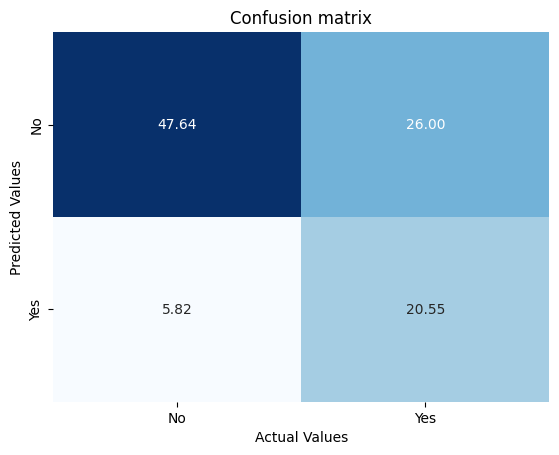

In [294]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

cutoff = 0.22

model = grid_roc

prob_pred = model.predict_proba(x_test)[:, 1]
predictions_test = (prob_pred >= cutoff).astype(int)

test_conf_matrix = confusion_matrix(y_test, predictions_test)
test_conf_matrix_percentage = test_conf_matrix.astype('float') / test_conf_matrix.sum() * 100
test_conf_matrix_percentage = np.round(test_conf_matrix_percentage, 2) 
labels = ['No', 'Yes']

fig, ax = plt.subplots()
label_names = ['TN','FN','FP','TP']
label_counts = ['{0:0.0f}'.format(value) for value in test_conf_matrix_percentage.flatten()]

# Draw heatmap using confusion matrix
import seaborn as sns
sns.heatmap(test_conf_matrix_percentage, annot=True, fmt='.2f', cmap="Blues",
            xticklabels=labels, yticklabels=labels, cbar=False)

ax.set_title('Confusion matrix')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values');

### ROC Curve

Optimal Threshold: 0.22


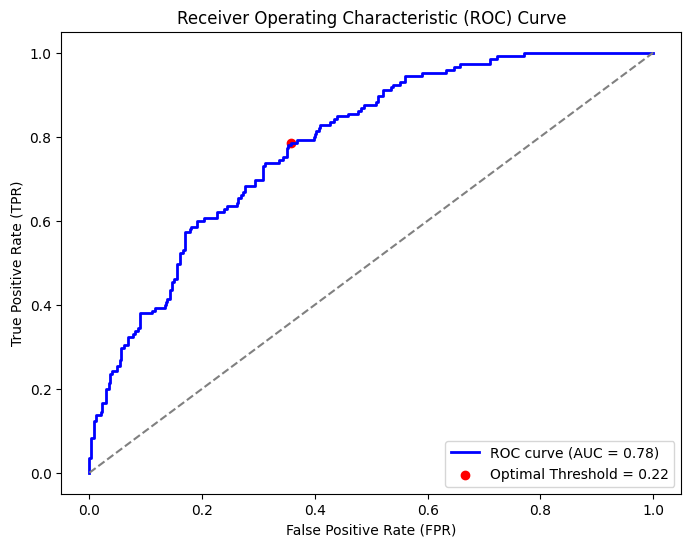

In [295]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, prob_pred)
roc_auc = auc(fpr, tpr)  
optimal_idx = np.argmax(tpr - fpr)  # Best trade-off between TPR and FPR
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.2f}")

# ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classification

# Highlight optimal threshold 
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o',
            label=f'Optimal Threshold = {optimal_threshold:.2f}')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Create a function to use the model to predict the popularity of a new song

In [296]:
def predict_popularity(model: xgb.XGBClassifier, song_features: dict, cutoff: float) -> dict:
    """
    Predicts the popularity of a new song based on its features.
    
    Args:
        model: Trained XGBoost model
        song_features: Dictionary containing song features
        cutoff: Cutoff value for the prediction
    Returns:
        Dictionary containing the prediction, the cutoff value, and whether the song is popular or not
    ```python
    {
        'prediction': 0.87,
        'is_popular': True,
        'cutoff': 0.72
    }
    ```
    
    """

    required_features = df.columns.tolist()
    if not all(feature in song_features for feature in required_features):
        raise ValueError(f"Missing required features: {set(required_features) - set(song_features.keys())}")

    if not cutoff:
        raise ValueError("Cutoff must be provided")

    # Convert song_features to a DataFrame
    song_features_df = pd.DataFrame([song_features])
    
    # Make prediction
    prediction = model.predict_proba(song_features_df)[:, 1][0]
    is_popular = prediction >= cutoff   
    return {
        'prediction': prediction,
        'is_popular': is_popular,
        'cutoff': cutoff
    }

#### Test the function

In [297]:
song_features = df_backup[df_backup['popular'] == True].sample(n=1).drop(columns=['popular']).iloc[0].to_dict()

result = predict_popularity(model=model, song_features=song_features, cutoff=cutoff)
is_popular = result['is_popular']
cutoff = result['cutoff']
prediction = result['prediction']

SEPARATOR = "="*40

print("\n" + SEPARATOR)
print("🎵 Song Popularity Prediction 🎵")
print(SEPARATOR)
print(f"Predicting popularity for a song with the following features:")
song_table = pd.DataFrame([song_features])
print(song_table)
print(SEPARATOR)
print(f"Prediction Score : {prediction:.2f}")
print(f"Decision Cutoff  : {cutoff:.2f}")
print(f"Result           : {'✅ Popular' if is_popular else '❌ Not Popular'}")
print(SEPARATOR + "\n")



🎵 Song Popularity Prediction 🎵
Predicting popularity for a song with the following features:
   artist_popularity  danceability  energy   key  loudness  mode  speechiness  \
0               87.0         0.789   0.706  11.0      62.0   0.0       0.0429   

   acousticness  instrumentalness  liveness  ...    tempo  duration_ms  \
0         0.112          0.000017    0.0586  ...  125.911     235493.0   

   album_songs  genre_pop  genre_rap  genre_dance pop  genre_hip hop  \
0          4.0        1.0        0.0              0.0            0.0   

   genre_pop rap  genre_rock  genre_r&b  
0            0.0         0.0        0.0  

[1 rows x 21 columns]
Prediction Score : 0.53
Decision Cutoff  : 0.22
Result           : ✅ Popular

